# Imports

In [1]:
# filtering messages to error
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# python imports
from itertools import cycle

# third-party imports
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import torch

import torch.nn as nn
from torch.autograd import Variable

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from matplotlib import pyplot as plt
%matplotlib inline

# project imports
from inference import SVI
from inference import ImportanceWeightedSampler
from models import VariationalAutoencoder
from models import StackedDeepGenerativeModel

from utils.math import mse_loss
from utils.data import load_data
from utils.data import get_initial_sample
from utils.data import get_unlabeled_data
from utils.data import get_labeled_and_unlabeled_data

# Loading Data

In [3]:
X_unlabeled, _ = load_data('datasets/vulns-unlabeled.csv')
X_labeled, y_labeled = load_data('datasets/vulns-labeled.csv')

# Pipeline

In [4]:
def run_pipeline(classifier, X_unlabeled, X, y,
                 n_queries, initial_size, test_size,
                 epochs=500, verbose=False):
    
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=test_size)

    # choosing randomly n elements from the dataset
    initial_idx = get_initial_sample(y_pool, initial_size)

    # selecting elements and removing then from the training dataset
    X_initial, y_initial = X_pool[initial_idx], y_pool[initial_idx]
    X_pool, y_pool = np.delete(X_pool, initial_idx, axis=0), np.delete(y_pool, initial_idx, axis=0)

    X_initial, y_initial = shuffle(X_initial, y_initial)
    X_pool, y_pool = shuffle(X_pool, y_pool)
    X_test, y_test = shuffle(X_test, y_test)

    # active learning
    
    learner = ActiveLearner(
        estimator=classifier, query_strategy=uncertainty_sampling, 
        X_training=X_initial, y_training=y_initial)

    # initializing labeled arrays
    X_labeled = np.zeros((n_queries, X_pool.shape[1]), dtype=int)
    y_labeled = np.zeros(n_queries, dtype=int)

    for i in range(n_queries):
        # value selected to be learn
        query_idx, query_inst = learner.query(X_pool)

        # saving labeled data by the specialists        
        X_labeled[i, ] = query_inst
        y_labeled[i] = y_pool[query_idx][0]

        # retraining
        learner.teach(query_inst.reshape(1, -1), y_pool[query_idx])

        # remove labeled value from the pool
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        
    score_active = learner.score(X_test, y_test)

    # append entries labeled by specialists to X_initial
    X_train_labeled = np.append(X_initial, X_labeled, axis=0)
    y_train_labeled = np.append(y_initial, y_labeled)

    # shuffling data
    X_train_labeled, y_train_labeled = shuffle(X_train_labeled, y_train_labeled)
    
    # scaling
    scaler = StandardScaler().fit(X_unlabeled)
    X_unlabeled = scaler.transform(X_unlabeled)
    X_train_labeled = scaler.transform(X_train_labeled)    
    X_test = scaler.transform(X_test)
    
    # neural network
    
    unlabeled_vae = get_unlabeled_data(X_unlabeled, 64)
    
    labeled, unlabeled, validation =\
        get_labeled_and_unlabeled_data(X_unlabeled, X_train_labeled, y_train_labeled, 64)
    
    alpha = 0.1 * (len(unlabeled) + len(labeled)) / len(labeled)
    
    input_dim = X_train_labeled.shape[1]
    label_dim = np.unique(y_train_labeled).shape[0]
    hidden_dim = [128, 64]
    latent_dim = 16
    
    # VAE
    
    features = VariationalAutoencoder([input_dim, latent_dim, hidden_dim])
    features.decoder.output_activation = nn.Identity()
    
    if torch.cuda.is_available():
        features.cuda(device=0)
    
    optimizer = torch.optim.Adam(features.parameters(), lr=1e-3, betas=(0.9, 0.999))
    
    elbo_vae_list = []
    for epoch in range(epochs):
        features.train()
        total_loss = 0
        
        for (u, _) in unlabeled_vae:
            u = Variable(u)

            if torch.cuda.is_available():
                u = u.cuda(device=0)
            
            reconstruction = features(u)

            likelihood = -mse_loss(reconstruction, u)
            elbo = likelihood - features.kl_divergence

            L = -torch.mean(elbo)

            L.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += L.data

        m = len(unlabeled_vae)
        elbo_vae_list.append((total_loss / m).tolist())
        
        if verbose:
            print(f"[Epoch: {epoch}]\t L: {total_loss / m:.2f}, accuracy: {accuracy / m:.2f}")
    
    # M1 + M2
    
    model = StackedDeepGenerativeModel([input_dim, label_dim, latent_dim, hidden_dim], features)
    model.decoder.output_activation = nn.Identity()
    model.classifier = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, label_dim),
        nn.Softmax()
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

    if torch.cuda.is_available(): 
        model = model.cuda()

    elbo = SVI(model, likelihood=mse_loss, sampler=ImportanceWeightedSampler(mc=1, iw=1))

    elbo_vae_stacked_list = []
    for epoch in range(epochs):
        model.train()
        total_loss, accuracy = (0, 0)
        for (x, y), (u, _) in zip(cycle(labeled), unlabeled):
            # Wrap in variables
            x, y, u = Variable(x), Variable(y), Variable(u)

            if torch.cuda.is_available():
                # They need to be on the same device and be synchronized.
                x, y = x.cuda(device=0), y.cuda(device=0)
                u = u.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(u)

            # Add auxiliary classification loss q(y|x)
            logits = model.classify(x)

            # Regular cross entropy
            classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L - alpha * classication_loss + U

            J_alpha.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += J_alpha.data
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(unlabeled)
        elbo_vae_stacked_list.append((total_loss / m).tolist())
        
        if verbose:
            print(f"[Epoch: {epoch}]\t J_a: {total_loss / m:.2f}, accuracy: {accuracy / m:.2f}")
    
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)
    
    if torch.cuda.is_available():
        X_test_tensor = torch.Tensor(X_test).cuda(device=0)
        y_test_tensor = torch.Tensor(y_test).cuda(device=0)
    
    model.eval()
    logits = model.classify(X_test_tensor)
    y_pred = torch.max(logits, 1)[1].data

    score_stacked = torch.mean((y_pred == y_test_tensor).float()).tolist()
    cm_vae_stacked = confusion_matrix(y_test, y_pred.tolist())
    
    return score_active, score_stacked, elbo_vae_list, elbo_vae_stacked_list, cm_vae_stacked

# Execution

In [5]:
acc_active_list = list()
acc_stacked_list = list()

In [6]:
elbo_vae_list = None
elbo_vae_stacked_list = None
cm_vae_stacked = None

In [7]:
for i in range(30):
    acc_active, acc_stacked, elbo_vae_list, elbo_vae_stacked_list, cm_vae_stacked =\
        run_pipeline(GradientBoostingClassifier(), X_unlabeled, X_labeled, y_labeled, 
                     n_queries=100, initial_size=20, test_size=40)
    
    acc_active_list.append(acc_active)
    acc_stacked_list.append(acc_stacked)
    
    if i % 5 == 0 and i != 0:
        print(f'End of interaction #{i:02d}.')

End of interaction #05.
End of interaction #10.
End of interaction #15.
End of interaction #20.
End of interaction #25.


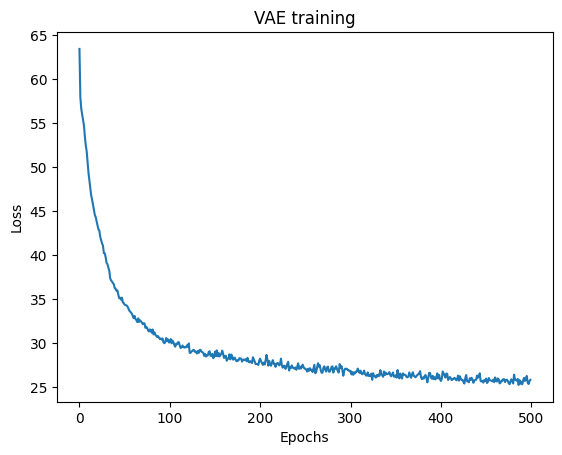

In [8]:
plt.figure()
plt.plot(elbo_vae_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE training")
plt.show()

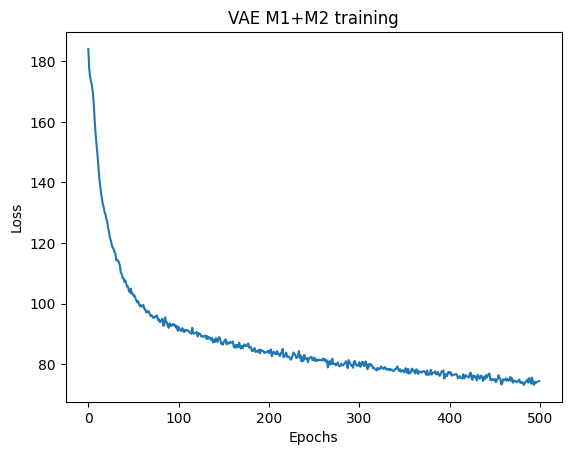

In [9]:
plt.figure()
plt.plot(elbo_vae_stacked_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE M1+M2 training")
plt.show()

In [10]:
print(f'# Avg. acc:')
print(f' - active: {np.mean(acc_active_list):.2f}')
print(f' - ladder: {np.mean(acc_stacked_list):.2f}')

# Avg. acc:
 - active: 0.73
 - ladder: 0.54


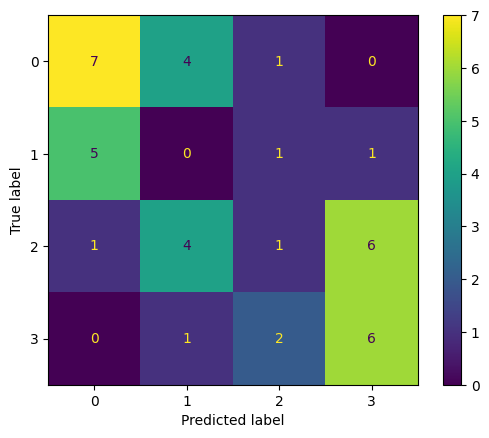

In [11]:
ConfusionMatrixDisplay(cm_vae_stacked).plot()
plt.show()